# Importando Bibliotecas
Vamos precisar de algumas bibliotecas neste projeto. Entre elas destacam-se:
- *PyTorch*: criar, treinar e testar a rede neural
- *matplotlib* e *seaborn*: plotar gráficos
- *pandas* e *NumPy*: pré-processamento
- *Optuna*: fine-tuning de hiperparâmetros

In [412]:
# Biblioteca Padrão
import os
import datetime
import importlib

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Processamento
import numpy as np
import random
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Optuna
import optuna
from optuna.trial import TrialState

Definindo uma seed padrão, para manter uma constância nos resultados, caso seja necessário rodar o projeto novamente.

In [413]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Selecionando o dispositivo para rodar o projeto (Prefencialmente GPU).

In [414]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Carregando e Processando os Dados
Iremos trabalhar com o valor de fechamento do *Bitcoin* no dia. Além disso, vamos configurar a coluna de data para ser o index do dataset.

In [415]:
dataset = pd.read_csv('../data/Bitstamp_BTCUSD_d.csv', index_col='date', parse_dates=True)
dataset

,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2024-06-04,1717459200,BTC/USD,68798.00,68868.00,68792.00,68857.00,6.283420e-01,4.326574e+04
2024-06-03,1717372800,BTC/USD,67744.00,70268.00,67590.00,68801.00,2.391376e+03,1.645291e+08
2024-06-02,1717286400,BTC/USD,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07
2024-06-01,1717200000,BTC/USD,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07
2024-05-31,1717113600,BTC/USD,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08
...,...,...,...,...,...,...,...,...
2014-12-02,1417478400,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
2014-12-01,1417392000,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
2014-11-30,1417305600,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03


Podemos verificar que a coluna 'symbol' apenas um único valor para todas as instâncias, por isso vamor removê-la.

In [416]:
dataset['symbol'].describe()

count        3477
unique          1
top       BTC/USD
freq         3477
Name: symbol, dtype: object

In [417]:
dataset.drop(['symbol'], axis=1, inplace=True)

Agora iremos remover instâncias que possuem alguma coluna com valor NA ou que sejam duplicatas.

In [418]:
# Invertendo o dataset
dataset = dataset.iloc[::-1]

# Verificar e remover valores nulos
dataset = dataset.dropna()

# Verificar e remover duplicatas
dataset = dataset.drop_duplicates()

In [419]:
dataset

,unix,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,
2014-11-28,1417132800,363.59,381.34,360.57,376.28,3.220878e+06,8.617150e+03
2014-11-29,1417219200,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03
2014-11-30,1417305600,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
2014-12-01,1417392000,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
2014-12-02,1417478400,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
...,...,...,...,...,...,...,...
2024-05-31,1717113600,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08
2024-06-01,1717200000,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07
2024-06-02,1717286400,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07


Vamos dividir o conjunto de dados em duas partes:
- `x`: contém todas as colunas exceto 'close' e 'unix'
- `y`: contém apenas a coluna 'close'

In [420]:
x, y = dataset.drop(columns=['close', 'unix']), dataset.close.values
x.shape, y.shape

((3477, 5), (3477,))

Em seguida, normalizamos os dados utilizando:
- `StandardScaler` para x, pois as varíaveis possuem diferentes escalas
- `MinMaxScaler` para y, para evitar problemas de explosão de gradiente e garantir que a rede neural convirja mais rapidamente no treinamento

In [421]:
# Normaliza os dados
ss = StandardScaler()
mm = MinMaxScaler()

x_trans = ss.fit_transform(x)
y_trans = mm.fit_transform(y.reshape(-1, 1))

# Análise Exploratória

In [422]:
dataset

,unix,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,
2014-11-28,1417132800,363.59,381.34,360.57,376.28,3.220878e+06,8.617150e+03
2014-11-29,1417219200,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03
2014-11-30,1417305600,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
2014-12-01,1417392000,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
2014-12-02,1417478400,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
...,...,...,...,...,...,...,...
2024-05-31,1717113600,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08
2024-06-01,1717200000,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07
2024-06-02,1717286400,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07


Definimos, então, um índice para separação do conjunto de dados em um subconjunto de, respectivamente, treinamento e teste. Vamos pegar 20% do dataset para teste.

In [423]:
train_test_cutoff = int(len(dataset) * 0.2)

### Visualização do Dataset

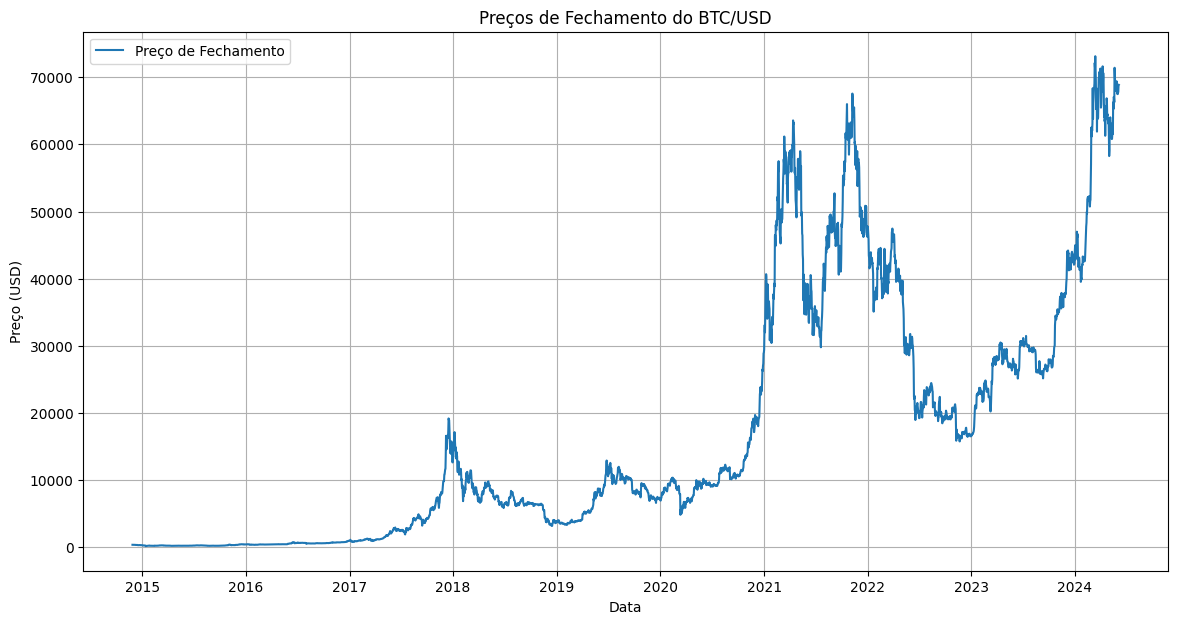

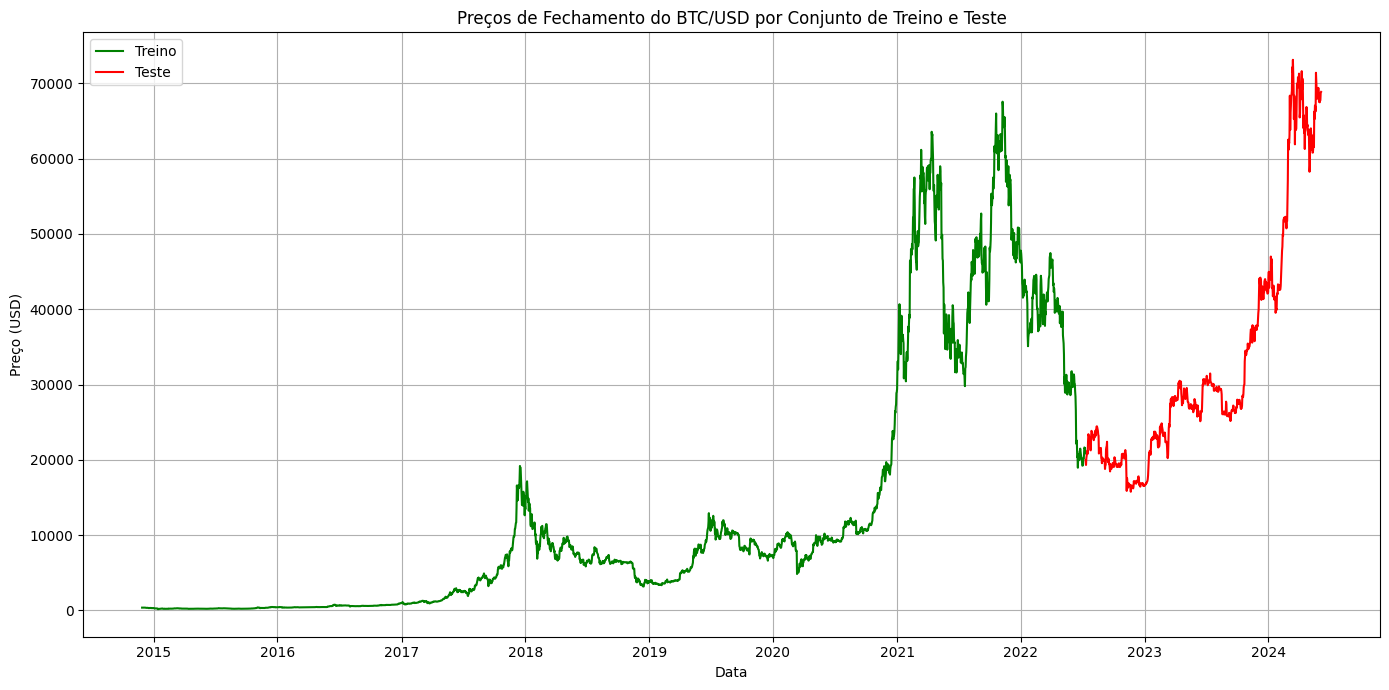

In [424]:
# Plotar os preços de fechamento ao longo do tempo
plt.figure(figsize=(14, 7))
plt.plot(dataset['close'], label='Preço de Fechamento')
plt.title('Preços de Fechamento do BTC/USD')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)

# Plotar os preços de fechamento do conjunto de treino e teste
plt.figure(figsize=(14, 7))
plt.plot(dataset.iloc[:-train_test_cutoff]['close'], label='Treino', color='green')
plt.plot(dataset.iloc[-train_test_cutoff:]['close'], label='Teste', color='red')
plt.title('Preços de Fechamento do BTC/USD por Conjunto de Treino e Teste')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

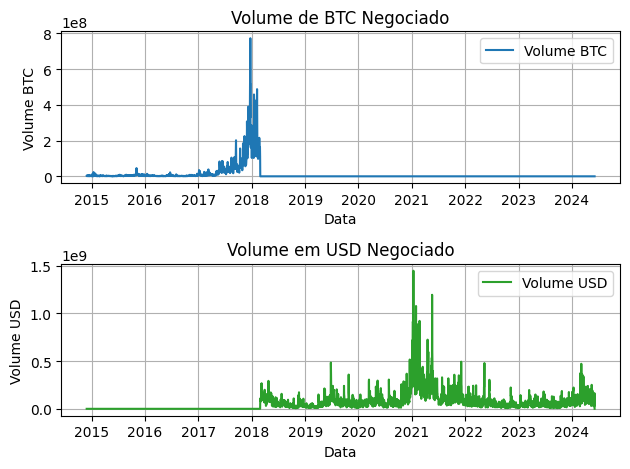

In [425]:
plt.subplot(2, 1, 1)
plt.plot(dataset['Volume BTC'], label='Volume BTC', color='tab:blue')
plt.title('Volume de BTC Negociado')
plt.xlabel('Data')
plt.ylabel('Volume BTC')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(dataset['Volume USD'], label='Volume USD', color='tab:green')
plt.title('Volume em USD Negociado')
plt.xlabel('Data')
plt.ylabel('Volume USD')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

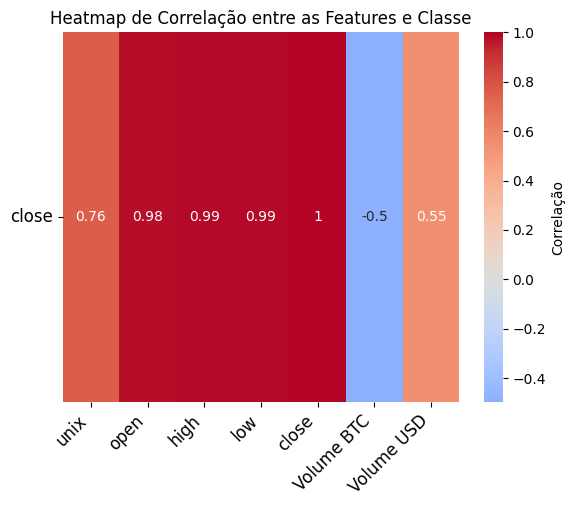

In [426]:
# Calcular a correlação entre preço e volume
correlation = dataset.corr(method='kendall', numeric_only=True)

sns.heatmap(correlation[['close']].T, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlação'})
plt.title('Heatmap de Correlação entre as Features e Classe')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

# Divisão dos Dados
O próximo passo é dividir os dados em sequências de entrada e saída.

As sequências serão formadas com base em:
- `n_prev_days`: número de dias anteriores, que serão usados como entrada para o modelo de previsão
- `n_next_days`: número de dias seguintes, que serão previstos pelo modelo

In [427]:
n_prev_days = 100
n_next_days = 50

# Nesse caso, serão usadas 5 informações (open, high, low, Volume BTC, Volume USD)
# dos últimos 100 dias para prever o preço de fechamento nos próximos 50 dias

Definimos, então, uma função utilitária para essa divisão em sequências. Em seguida, usamos essa função para dividir as partes `x` e `y` dos dados após as transformações anteriormente mencionadas.

In [428]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    x, y = [], []
    for i in range(len(input_sequences)):
        # Encontrando os últimos índices das sequências de entrada e saída
        end_idx = i + n_steps_in
        out_end_idx = end_idx + n_steps_out - 1

        # Bounds checking na entrada
        if out_end_idx > len(input_sequences):
            break

        # Pegando as sequências de entrada e saída do padrão
        seq_x, seq_y = input_sequences[i:end_idx], output_sequence[(end_idx - 1):out_end_idx, -1]
        x.append(seq_x)
        y.append(seq_y)

    return np.array(x), np.array(y)


x_ss, y_mm = split_sequences(x_trans, y_trans, n_prev_days, n_next_days)
print(x_ss.shape, y_mm.shape)

(3329, 100, 5) (3329, 50)


Após essa divisão, os conjuntos de treinamento e teste são criados usando o índice de corte definido anteriormente.

In [429]:
total_samples = len(x)

x_train = x_ss[:-train_test_cutoff]
x_test = x_ss[-train_test_cutoff:]

y_train = y_mm[:-train_test_cutoff]
y_test = y_mm[-train_test_cutoff:]

Convertemos, então, os dados de treinamento e teste para tensores do *PyTorch*, para que o modelo possa usá-los devidamente.

In [430]:
x_train_tensors = torch.Tensor(x_train)
x_test_tensors = torch.Tensor(x_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

Também é necessário adaptar a forma dos tensores. A nova estrutura será do tipo:

[*número de amostras*, *número de dias anteriores*, *número de características*]

In [431]:
x_train_tensors_final = torch.reshape(x_train_tensors,   
                                      (x_train_tensors.shape[0],
                                       n_prev_days,
                                       x_train_tensors.shape[2]))
x_test_tensors_final = torch.reshape(x_test_tensors,  
                                     (x_test_tensors.shape[0],
                                      n_prev_days,
                                      x_test_tensors.shape[2]))

In [432]:
x_train, y_train

(array([[[-0.8952886 , -0.89532915, -0.89468832, -0.16654334,
          -0.64150103],
         [-0.89459062, -0.89504987, -0.89403503, -0.17796782,
          -0.64151502],
         [-0.89458245, -0.89529464, -0.89397518, -0.21648709,
          -0.64155782],
         ...,
         [-0.90038938, -0.9006833 , -0.90019038, -0.17016407,
          -0.64147307],
         [-0.90017341, -0.9008978 , -0.89981004, -0.19815042,
          -0.64151755],
         [-0.90020278, -0.90073746, -0.89975411, -0.20697649,
          -0.64153173]],
 
        [[-0.89459062, -0.89504987, -0.89403503, -0.17796782,
          -0.64151502],
         [-0.89458245, -0.89529464, -0.89397518, -0.21648709,
          -0.64155782],
         [-0.8945917 , -0.89527764, -0.8939914 , -0.1833945 ,
          -0.64152098],
         ...,
         [-0.90017341, -0.9008978 , -0.89981004, -0.19815042,
          -0.64151755],
         [-0.90020278, -0.90073746, -0.89975411, -0.20697649,
          -0.64153173],
         [-0.90007603, 

In [433]:
x_test, y_test

(array([[[ 1.38249738e+00,  1.35582774e+00,  1.42773242e+00,
          -2.44043500e-01, -4.20497568e-01],
         [ 1.37411123e+00,  1.36071677e+00,  1.41053099e+00,
          -2.44025320e-01, -9.04828043e-02],
         [ 1.40069994e+00,  1.46234050e+00,  1.46058819e+00,
          -2.44013238e-01,  1.64127211e-01],
         ...,
         [ 6.72218552e-01,  6.57165800e-01,  7.02410850e-01,
          -2.44044102e-01, -4.94506456e-01],
         [ 6.84385142e-01,  7.01583904e-01,  7.18873414e-01,
          -2.44024164e-01, -2.34702051e-01],
         [ 7.31406369e-01,  7.10632439e-01,  6.98192993e-01,
          -2.44003955e-01, -1.66120765e-03]],
 
        [[ 1.37411123e+00,  1.36071677e+00,  1.41053099e+00,
          -2.44025320e-01, -9.04828043e-02],
         [ 1.40069994e+00,  1.46234050e+00,  1.46058819e+00,
          -2.44013238e-01,  1.64127211e-01],
         [ 1.51078244e+00,  1.45199166e+00,  1.50773188e+00,
          -2.44025778e-01, -8.13752877e-02],
         ...,
         [ 6.84

# Definindo a classe LSTM
Como modelo de previsão, vamos usar uma rede neural com um número variável de camadas LSTM e duas camadas Fully Connected.

O método `forward` implementa o *forward pass* da rede. Ele propaga a entrada através da camada LSTM, aplicando funções de ativação ReLU entre as camadas Fully Connected. Por fim, retorna a saída da rede.

Ainda nesse método, as variáveis com prefixo `h` (`h0` e `hn`) representam o estado da célula LSTM que é atualizada e passada para cada passo de tempo subsequente durante a execução. Ele captura informações relevantes sobre os dados de entrada até o momento atual.

Já as variáveis com prefixo `c` (`c0` e `cn`) representam a o estado da célula de memória. Assim como o estado oculto, ele matém informações relevantes de longo prazo sobre os dados de entrada.

In [434]:
class LSTM(nn.Module):
    input_size = 5 # open, high, low, Volume BTC, Volume USD

    def __init__(self, n_classes, hidden_size, n_layers, n_neurons, dropout_rate):
        super().__init__()

        self.n_classes = n_classes
        self.hidden_size = hidden_size 
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=hidden_size,
                            num_layers=n_layers, batch_first=True,
                            dropout=(dropout_rate if n_layers > 1 else 0))
        self.fc1 = nn.Linear(hidden_size, n_neurons)
        self.fc2 = nn.Linear(n_neurons, n_classes)


    def forward(self, x):
        # Estado Oculto
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size)
        # Estato de Célula
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size)
        output, (hn, cn) = self.lstm(x, (h0, c0))
        hn = hn[-1, :, :]
        out = F.relu(hn)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

# Definindo funções úteis
Aqui definimos as funções de treinamento de teste do modelo para 1 único epoch.

In [435]:
def train_model(model, criterion, optimizer, x_train, y_train):
    model.train().to(device)

    outputs = model(x_train)
    optimizer.zero_grad()

    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    return loss

In [436]:
def test_model(model, criterion, x_test, y_test):
    model.eval().to(device)

    with torch.no_grad():
        outputs = model(x_test)
        loss = criterion(outputs, y_test)

    return loss

# Fine-Tuning de Hiperparâmetros
Vamos usar o *Optuna* para testar diferentes combinações de hiperparâmetros para o modelo. Podemos decompor o que está sendo feito em 3 passos:

1. Configuração:
    - A classe LSTM, o número de epochs, o número de trials (combinações), e o critério (função de loss) são definidos.

2. Função Objetivo:
    - A função `objective` define o objetivo da otimização a ser realizada pelo *Optuna*.
    - Os hiperparâmetros são amostrados para cada tentativa usando os métodos `trial.suggest_*` do *Optuna*.
    - Um modelo LSTM é instanciado com os hiperparâmetros amostrados.
    - Um otimizador é selecionado e instanciado com base nos hiperparâmetros amostrados.
    - O modelo é treinado pelo número especificado de epochs usando a função `train_model`, e seu desempenho é avaliado usando a função `test_model`.
    - O resultado intermediário da tentativa (loss de teste) é relatado ao *Optuna* para poda.
    - Se a tentativa for considerada pouco promissora e deva ser podada, ela é terminada antecipadamente.
    - A loss de teste o caminho para o modelo treinado, são armazenados usando `trial.set_user_attr`.
    - O estado treinado do modelo é salvo em um arquivo com um nome de arquivo datado no diretório 'models'.

3. Otimização:
    - Um estudo do *Optuna* chamado 'BTC-LSTM' é criado para conduzir a otimização de hiperparâmetros.
    - A função objetivo é otimizada usando o método `study.optimize` com um número especificado de tentativas (`n_trials`).
    - As tentativas podadas são identificadas usando `study.get_trials`.

Esse processo explora iterativamente o espaço de hiperparâmetros para encontrar o conjunto de hiperparâmetros que maximizam a precisão do modelo LSTM no conjunto de dados de validação.

### Passo 1

In [437]:
ModelClass = LSTM
n_epochs = 100
n_trials = 50
criterion = nn.MSELoss().to(device)

### Passo 2

In [438]:
def objective(trial):
    trial.set_user_attr('network', ModelClass.__name__)
    trial.set_user_attr('total_epochs', n_epochs)

    hidden_size = trial.suggest_int("hidden_size", 2, 4)
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_neurons = trial.suggest_int("n_neurons", 100, 200, step=10)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.9, step=0.1)

    # Gera o modelo
    model = ModelClass(n_next_days, hidden_size, n_layers, n_neurons, dropout_rate)

    # Gera o otimizador
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr)

    # Treinamento e teste do modelo
    for epoch in range(n_epochs):
        train_loss = train_model(model, criterion, optimizer,
                                x_train_tensors_final, y_train_tensors)
        test_loss = test_model(model, criterion,
                            x_test_tensors_final, y_test_tensors)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # Poda (termina a combinação atual se não for promissora)
        trial.report(test_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Salva o estado do modelo
    current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = os.path.join("models", f"lstm_{current_datetime}.pth")
    torch.save(model.state_dict(), model_path)

    trial.set_user_attr("model_path", model_path)

    return test_loss

### Passo 3

In [439]:
study = optuna.create_study(study_name="BTC-LSTM", direction="minimize")

study.optimize(objective, n_trials)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])

[I 2024-06-12 02:02:11,570] A new study created in memory with name: BTC-LSTM


Epoch 1, Train Loss: 0.0967, Test Loss: 0.2304
Epoch 2, Train Loss: 0.0955, Test Loss: 0.2283
Epoch 3, Train Loss: 0.0945, Test Loss: 0.2261
Epoch 4, Train Loss: 0.0934, Test Loss: 0.2240
Epoch 5, Train Loss: 0.0924, Test Loss: 0.2220
Epoch 6, Train Loss: 0.0914, Test Loss: 0.2199
Epoch 7, Train Loss: 0.0904, Test Loss: 0.2179
Epoch 8, Train Loss: 0.0894, Test Loss: 0.2160
Epoch 9, Train Loss: 0.0885, Test Loss: 0.2141
Epoch 10, Train Loss: 0.0876, Test Loss: 0.2122
Epoch 11, Train Loss: 0.0867, Test Loss: 0.2104
Epoch 12, Train Loss: 0.0858, Test Loss: 0.2086
Epoch 13, Train Loss: 0.0850, Test Loss: 0.2068
Epoch 14, Train Loss: 0.0842, Test Loss: 0.2051
Epoch 15, Train Loss: 0.0834, Test Loss: 0.2034
Epoch 16, Train Loss: 0.0826, Test Loss: 0.2017
Epoch 17, Train Loss: 0.0818, Test Loss: 0.2000
Epoch 18, Train Loss: 0.0811, Test Loss: 0.1984
Epoch 19, Train Loss: 0.0804, Test Loss: 0.1968
Epoch 20, Train Loss: 0.0796, Test Loss: 0.1953
Epoch 21, Train Loss: 0.0790, Test Loss: 0.1937
E

[I 2024-06-12 02:02:23,377] Trial 0 finished with value: 0.12648919224739075 and parameters: {'hidden_size': 4, 'n_layers': 1, 'n_neurons': 130, 'dropout_rate': 0.4, 'optimizer': 'SGD', 'lr': 0.046818292601628314}. Best is trial 0 with value: 0.12648919224739075.


Epoch 98, Train Loss: 0.0548, Test Loss: 0.1274
Epoch 99, Train Loss: 0.0546, Test Loss: 0.1269
Epoch 100, Train Loss: 0.0545, Test Loss: 0.1265
Epoch 1, Train Loss: 0.1032, Test Loss: 0.2413
Epoch 2, Train Loss: 0.1031, Test Loss: 0.2413
Epoch 3, Train Loss: 0.1031, Test Loss: 0.2413
Epoch 4, Train Loss: 0.1031, Test Loss: 0.2413
Epoch 5, Train Loss: 0.1031, Test Loss: 0.2412
Epoch 6, Train Loss: 0.1031, Test Loss: 0.2412
Epoch 7, Train Loss: 0.1031, Test Loss: 0.2412
Epoch 8, Train Loss: 0.1031, Test Loss: 0.2412
Epoch 9, Train Loss: 0.1031, Test Loss: 0.2411
Epoch 10, Train Loss: 0.1030, Test Loss: 0.2411
Epoch 11, Train Loss: 0.1030, Test Loss: 0.2411
Epoch 12, Train Loss: 0.1030, Test Loss: 0.2411
Epoch 13, Train Loss: 0.1030, Test Loss: 0.2410
Epoch 14, Train Loss: 0.1030, Test Loss: 0.2410
Epoch 15, Train Loss: 0.1030, Test Loss: 0.2410
Epoch 16, Train Loss: 0.1030, Test Loss: 0.2410
Epoch 17, Train Loss: 0.1030, Test Loss: 0.2410
Epoch 18, Train Loss: 0.1030, Test Loss: 0.2409


[I 2024-06-12 02:02:31,457] Trial 1 finished with value: 0.23908880352973938 and parameters: {'hidden_size': 2, 'n_layers': 1, 'n_neurons': 160, 'dropout_rate': 0.2, 'optimizer': 'SGD', 'lr': 0.0002416376103241379}. Best is trial 0 with value: 0.12648919224739075.


Epoch 100, Train Loss: 0.1020, Test Loss: 0.2391
Epoch 1, Train Loss: 0.1300, Test Loss: 0.5578
Epoch 2, Train Loss: 0.9005, Test Loss: 0.2058
Epoch 3, Train Loss: 0.0858, Test Loss: 0.1231
Epoch 4, Train Loss: 0.0552, Test Loss: 0.1048
Epoch 5, Train Loss: 0.0532, Test Loss: 0.1027
Epoch 6, Train Loss: 0.0523, Test Loss: 0.0908
Epoch 7, Train Loss: 0.0500, Test Loss: 0.0670
Epoch 8, Train Loss: 0.0430, Test Loss: 0.0289
Epoch 9, Train Loss: 0.0301, Test Loss: 0.0109
Epoch 10, Train Loss: 0.0217, Test Loss: 0.0228
Epoch 11, Train Loss: 0.0180, Test Loss: 0.0068
Epoch 12, Train Loss: 0.0149, Test Loss: 0.0396
Epoch 13, Train Loss: 0.0163, Test Loss: 0.0063
Epoch 14, Train Loss: 0.0143, Test Loss: 0.0396
Epoch 15, Train Loss: 0.0146, Test Loss: 0.0059
Epoch 16, Train Loss: 0.0105, Test Loss: 0.0260
Epoch 17, Train Loss: 0.0101, Test Loss: 0.0065
Epoch 18, Train Loss: 0.0087, Test Loss: 0.0205
Epoch 19, Train Loss: 0.0084, Test Loss: 0.0068
Epoch 20, Train Loss: 0.0077, Test Loss: 0.0180


[I 2024-06-12 02:02:40,889] Trial 2 finished with value: 0.013214067555963993 and parameters: {'hidden_size': 2, 'n_layers': 1, 'n_neurons': 100, 'dropout_rate': 0.2, 'optimizer': 'RMSprop', 'lr': 0.006544603291216663}. Best is trial 2 with value: 0.013214067555963993.


Epoch 98, Train Loss: 0.0050, Test Loss: 0.0132
Epoch 99, Train Loss: 0.0051, Test Loss: 0.0073
Epoch 100, Train Loss: 0.0050, Test Loss: 0.0132
Epoch 1, Train Loss: 0.1018, Test Loss: 0.2382
Epoch 2, Train Loss: 0.1018, Test Loss: 0.2381
Epoch 3, Train Loss: 0.1018, Test Loss: 0.2381
Epoch 4, Train Loss: 0.1018, Test Loss: 0.2381
Epoch 5, Train Loss: 0.1019, Test Loss: 0.2381
Epoch 6, Train Loss: 0.1018, Test Loss: 0.2381
Epoch 7, Train Loss: 0.1018, Test Loss: 0.2381
Epoch 8, Train Loss: 0.1018, Test Loss: 0.2381
Epoch 9, Train Loss: 0.1018, Test Loss: 0.2381
Epoch 10, Train Loss: 0.1018, Test Loss: 0.2381
Epoch 11, Train Loss: 0.1018, Test Loss: 0.2381
Epoch 12, Train Loss: 0.1018, Test Loss: 0.2381
Epoch 13, Train Loss: 0.1018, Test Loss: 0.2381
Epoch 14, Train Loss: 0.1018, Test Loss: 0.2381
Epoch 15, Train Loss: 0.1018, Test Loss: 0.2380
Epoch 16, Train Loss: 0.1018, Test Loss: 0.2380
Epoch 17, Train Loss: 0.1018, Test Loss: 0.2380
Epoch 18, Train Loss: 0.1018, Test Loss: 0.2380


[I 2024-06-12 02:02:57,719] Trial 3 finished with value: 0.23738731443881989 and parameters: {'hidden_size': 3, 'n_layers': 2, 'n_neurons': 150, 'dropout_rate': 0.5, 'optimizer': 'SGD', 'lr': 0.00012124834531943577}. Best is trial 2 with value: 0.013214067555963993.


Epoch 99, Train Loss: 0.1015, Test Loss: 0.2374
Epoch 100, Train Loss: 0.1015, Test Loss: 0.2374
Epoch 1, Train Loss: 0.0979, Test Loss: 0.1865
Epoch 2, Train Loss: 0.3411, Test Loss: 0.0627
Epoch 3, Train Loss: 0.0899, Test Loss: 0.1922
Epoch 4, Train Loss: 0.0869, Test Loss: 0.3250
Epoch 5, Train Loss: 0.1605, Test Loss: 0.2903
Epoch 6, Train Loss: 0.1439, Test Loss: 0.1699
Epoch 7, Train Loss: 0.0821, Test Loss: 0.0633
Epoch 8, Train Loss: 0.0402, Test Loss: 0.0272
Epoch 9, Train Loss: 0.0424, Test Loss: 0.0621
Epoch 10, Train Loss: 0.0620, Test Loss: 0.0784
Epoch 11, Train Loss: 0.0652, Test Loss: 0.0566
Epoch 12, Train Loss: 0.0502, Test Loss: 0.0361
Epoch 13, Train Loss: 0.0351, Test Loss: 0.0354
Epoch 14, Train Loss: 0.0252, Test Loss: 0.0432
Epoch 15, Train Loss: 0.0208, Test Loss: 0.0480
Epoch 16, Train Loss: 0.0172, Test Loss: 0.0521
Epoch 17, Train Loss: 0.0152, Test Loss: 0.0623
Epoch 18, Train Loss: 0.0149, Test Loss: 0.0686
Epoch 19, Train Loss: 0.0153, Test Loss: 0.0594


[I 2024-06-12 02:03:14,663] Trial 4 finished with value: 0.020230472087860107 and parameters: {'hidden_size': 3, 'n_layers': 2, 'n_neurons': 160, 'dropout_rate': 0.8, 'optimizer': 'Adam', 'lr': 0.028313233192650597}. Best is trial 2 with value: 0.013214067555963993.


Epoch 100, Train Loss: 0.0039, Test Loss: 0.0202
Epoch 1, Train Loss: 0.1004, Test Loss: 0.2301


[I 2024-06-12 02:03:15,369] Trial 5 pruned. 


Epoch 2, Train Loss: 0.1003, Test Loss: 0.2299


[I 2024-06-12 02:03:15,675] Trial 6 pruned. 
[I 2024-06-12 02:03:15,782] Trial 7 pruned. 


Epoch 1, Train Loss: 0.1099, Test Loss: 0.2505
Epoch 1, Train Loss: 0.0997, Test Loss: 0.8035
Epoch 1, Train Loss: 0.1132, Test Loss: 0.0944
Epoch 2, Train Loss: 0.1057, Test Loss: 0.0632
Epoch 3, Train Loss: 0.0832, Test Loss: 0.0939
Epoch 4, Train Loss: 0.0785, Test Loss: 0.1302
Epoch 5, Train Loss: 0.0794, Test Loss: 0.1383
Epoch 6, Train Loss: 0.0703, Test Loss: 0.1232
Epoch 7, Train Loss: 0.0570, Test Loss: 0.0990
Epoch 8, Train Loss: 0.0474, Test Loss: 0.0774
Epoch 9, Train Loss: 0.0449, Test Loss: 0.0629
Epoch 10, Train Loss: 0.0441, Test Loss: 0.0515
Epoch 11, Train Loss: 0.0389, Test Loss: 0.0416
Epoch 12, Train Loss: 0.0301, Test Loss: 0.0361
Epoch 13, Train Loss: 0.0213, Test Loss: 0.0376
Epoch 14, Train Loss: 0.0147, Test Loss: 0.0469
Epoch 15, Train Loss: 0.0119, Test Loss: 0.0618
Epoch 16, Train Loss: 0.0121, Test Loss: 0.0788
Epoch 17, Train Loss: 0.0132, Test Loss: 0.0929
Epoch 18, Train Loss: 0.0147, Test Loss: 0.1012
Epoch 19, Train Loss: 0.0151, Test Loss: 0.1037
Epo

[I 2024-06-12 02:03:30,300] Trial 8 finished with value: 0.015306241810321808 and parameters: {'hidden_size': 2, 'n_layers': 2, 'n_neurons': 160, 'dropout_rate': 0.5, 'optimizer': 'Adam', 'lr': 0.01450151096828059}. Best is trial 2 with value: 0.013214067555963993.


Epoch 99, Train Loss: 0.0050, Test Loss: 0.0157
Epoch 100, Train Loss: 0.0050, Test Loss: 0.0153


[I 2024-06-12 02:03:30,466] Trial 9 pruned. 


Epoch 1, Train Loss: 0.1134, Test Loss: 0.2529
Epoch 1, Train Loss: 0.1191, Test Loss: 0.1331
Epoch 2, Train Loss: 0.0668, Test Loss: 0.1163
Epoch 3, Train Loss: 0.0524, Test Loss: 0.1007
Epoch 4, Train Loss: 0.0447, Test Loss: 0.0897
Epoch 5, Train Loss: 0.0391, Test Loss: 0.0810
Epoch 6, Train Loss: 0.0339, Test Loss: 0.0726
Epoch 7, Train Loss: 0.0292, Test Loss: 0.0654
Epoch 8, Train Loss: 0.0251, Test Loss: 0.0590
Epoch 9, Train Loss: 0.0217, Test Loss: 0.0538
Epoch 10, Train Loss: 0.0188, Test Loss: 0.0496
Epoch 11, Train Loss: 0.0166, Test Loss: 0.0463
Epoch 12, Train Loss: 0.0148, Test Loss: 0.0437
Epoch 13, Train Loss: 0.0134, Test Loss: 0.0417
Epoch 14, Train Loss: 0.0124, Test Loss: 0.0401
Epoch 15, Train Loss: 0.0115, Test Loss: 0.0388
Epoch 16, Train Loss: 0.0109, Test Loss: 0.0377
Epoch 17, Train Loss: 0.0103, Test Loss: 0.0368
Epoch 18, Train Loss: 0.0099, Test Loss: 0.0360
Epoch 19, Train Loss: 0.0095, Test Loss: 0.0353
Epoch 20, Train Loss: 0.0092, Test Loss: 0.0346
Ep

[I 2024-06-12 02:03:38,593] Trial 10 finished with value: 0.018085796386003494 and parameters: {'hidden_size': 2, 'n_layers': 1, 'n_neurons': 100, 'dropout_rate': 0.30000000000000004, 'optimizer': 'RMSprop', 'lr': 0.001116095473310328}. Best is trial 2 with value: 0.013214067555963993.


Epoch 99, Train Loss: 0.0042, Test Loss: 0.0140
Epoch 100, Train Loss: 0.0042, Test Loss: 0.0181
Epoch 1, Train Loss: 0.1004, Test Loss: 0.1895
Epoch 2, Train Loss: 0.0842, Test Loss: 0.1638
Epoch 3, Train Loss: 0.0729, Test Loss: 0.1417
Epoch 4, Train Loss: 0.0654, Test Loss: 0.1239
Epoch 5, Train Loss: 0.0609, Test Loss: 0.1105
Epoch 6, Train Loss: 0.0584, Test Loss: 0.1011


[I 2024-06-12 02:03:39,814] Trial 11 pruned. 


Epoch 7, Train Loss: 0.0573, Test Loss: 0.0951
Epoch 8, Train Loss: 0.0569, Test Loss: 0.0919


[I 2024-06-12 02:03:40,174] Trial 12 pruned. 


Epoch 1, Train Loss: 0.1114, Test Loss: 4.7586
Epoch 1, Train Loss: 0.1146, Test Loss: 0.1139
Epoch 2, Train Loss: 0.0782, Test Loss: 0.1242
Epoch 3, Train Loss: 0.0586, Test Loss: 0.1030
Epoch 4, Train Loss: 0.0530, Test Loss: 0.1003
Epoch 5, Train Loss: 0.0499, Test Loss: 0.0943
Epoch 6, Train Loss: 0.0470, Test Loss: 0.0897
Epoch 7, Train Loss: 0.0441, Test Loss: 0.0849


[I 2024-06-12 02:03:41,024] Trial 13 pruned. 
[I 2024-06-12 02:03:41,197] Trial 14 pruned. 


Epoch 8, Train Loss: 0.0410, Test Loss: 0.0802
Epoch 1, Train Loss: 0.1084, Test Loss: 0.7616
Epoch 1, Train Loss: 0.1056, Test Loss: 0.0927
Epoch 2, Train Loss: 0.0538, Test Loss: 0.0438
Epoch 3, Train Loss: 0.0482, Test Loss: 0.0314
Epoch 4, Train Loss: 0.0394, Test Loss: 0.0292
Epoch 5, Train Loss: 0.0266, Test Loss: 0.0283
Epoch 6, Train Loss: 0.0172, Test Loss: 0.0278
Epoch 7, Train Loss: 0.0141, Test Loss: 0.0271
Epoch 8, Train Loss: 0.0144, Test Loss: 0.0258
Epoch 9, Train Loss: 0.0146, Test Loss: 0.0240
Epoch 10, Train Loss: 0.0136, Test Loss: 0.0221
Epoch 11, Train Loss: 0.0119, Test Loss: 0.0204
Epoch 12, Train Loss: 0.0102, Test Loss: 0.0190
Epoch 13, Train Loss: 0.0090, Test Loss: 0.0180
Epoch 14, Train Loss: 0.0084, Test Loss: 0.0176
Epoch 15, Train Loss: 0.0082, Test Loss: 0.0177
Epoch 16, Train Loss: 0.0081, Test Loss: 0.0178
Epoch 17, Train Loss: 0.0078, Test Loss: 0.0177
Epoch 18, Train Loss: 0.0074, Test Loss: 0.0168
Epoch 19, Train Loss: 0.0069, Test Loss: 0.0154
Epo

[I 2024-06-12 02:03:51,405] Trial 15 finished with value: 0.01086514350026846 and parameters: {'hidden_size': 3, 'n_layers': 1, 'n_neurons': 130, 'dropout_rate': 0.30000000000000004, 'optimizer': 'Adam', 'lr': 0.013184477246114278}. Best is trial 15 with value: 0.01086514350026846.
[I 2024-06-12 02:03:51,552] Trial 16 pruned. 


Epoch 100, Train Loss: 0.0026, Test Loss: 0.0109
Epoch 1, Train Loss: 0.1150, Test Loss: 0.2252
Epoch 1, Train Loss: 0.0949, Test Loss: 0.1608
Epoch 2, Train Loss: 0.0681, Test Loss: 0.1352
Epoch 3, Train Loss: 0.0590, Test Loss: 0.1178
Epoch 4, Train Loss: 0.0536, Test Loss: 0.1051
Epoch 5, Train Loss: 0.0497, Test Loss: 0.0953
Epoch 6, Train Loss: 0.0464, Test Loss: 0.0869


[I 2024-06-12 02:03:52,636] Trial 17 pruned. 


Epoch 7, Train Loss: 0.0435, Test Loss: 0.0796
Epoch 8, Train Loss: 0.0408, Test Loss: 0.0731
Epoch 1, Train Loss: 0.1042, Test Loss: 0.0857
Epoch 2, Train Loss: 0.1022, Test Loss: 0.1246
Epoch 3, Train Loss: 0.0567, Test Loss: 0.0809
Epoch 4, Train Loss: 0.0430, Test Loss: 0.0738
Epoch 5, Train Loss: 0.0371, Test Loss: 0.0632
Epoch 6, Train Loss: 0.0315, Test Loss: 0.0541
Epoch 7, Train Loss: 0.0264, Test Loss: 0.0462
Epoch 8, Train Loss: 0.0220, Test Loss: 0.0404
Epoch 9, Train Loss: 0.0182, Test Loss: 0.0362
Epoch 10, Train Loss: 0.0153, Test Loss: 0.0337
Epoch 11, Train Loss: 0.0131, Test Loss: 0.0325
Epoch 12, Train Loss: 0.0115, Test Loss: 0.0320
Epoch 13, Train Loss: 0.0104, Test Loss: 0.0315
Epoch 14, Train Loss: 0.0096, Test Loss: 0.0316
Epoch 15, Train Loss: 0.0090, Test Loss: 0.0309
Epoch 16, Train Loss: 0.0086, Test Loss: 0.0324
Epoch 17, Train Loss: 0.0085, Test Loss: 0.0287
Epoch 18, Train Loss: 0.0092, Test Loss: 0.0362
Epoch 19, Train Loss: 0.0109, Test Loss: 0.0268
Epo

[I 2024-06-12 02:04:03,887] Trial 18 finished with value: 0.015611110255122185 and parameters: {'hidden_size': 3, 'n_layers': 1, 'n_neurons': 130, 'dropout_rate': 0.2, 'optimizer': 'RMSprop', 'lr': 0.0019709283209777303}. Best is trial 15 with value: 0.01086514350026846.


Epoch 100, Train Loss: 0.0039, Test Loss: 0.0156
Epoch 1, Train Loss: 0.1152, Test Loss: 0.0876
Epoch 2, Train Loss: 0.0651, Test Loss: 0.0466
Epoch 3, Train Loss: 0.0594, Test Loss: 0.0402
Epoch 4, Train Loss: 0.0480, Test Loss: 0.0334
Epoch 5, Train Loss: 0.0324, Test Loss: 0.0245
Epoch 6, Train Loss: 0.0199, Test Loss: 0.0233
Epoch 7, Train Loss: 0.0152, Test Loss: 0.0255
Epoch 8, Train Loss: 0.0155, Test Loss: 0.0232
Epoch 9, Train Loss: 0.0153, Test Loss: 0.0212
Epoch 10, Train Loss: 0.0143, Test Loss: 0.0213
Epoch 11, Train Loss: 0.0130, Test Loss: 0.0215
Epoch 12, Train Loss: 0.0114, Test Loss: 0.0205
Epoch 13, Train Loss: 0.0098, Test Loss: 0.0187
Epoch 14, Train Loss: 0.0088, Test Loss: 0.0171
Epoch 15, Train Loss: 0.0086, Test Loss: 0.0160
Epoch 16, Train Loss: 0.0086, Test Loss: 0.0152
Epoch 17, Train Loss: 0.0084, Test Loss: 0.0151
Epoch 18, Train Loss: 0.0080, Test Loss: 0.0157
Epoch 19, Train Loss: 0.0076, Test Loss: 0.0163
Epoch 20, Train Loss: 0.0072, Test Loss: 0.0163


[I 2024-06-12 02:04:14,596] Trial 19 finished with value: 0.00783726666122675 and parameters: {'hidden_size': 3, 'n_layers': 1, 'n_neurons': 110, 'dropout_rate': 0.4, 'optimizer': 'Adam', 'lr': 0.019263792304558942}. Best is trial 19 with value: 0.00783726666122675.
[I 2024-06-12 02:04:14,725] Trial 20 pruned. 


Epoch 100, Train Loss: 0.0027, Test Loss: 0.0078
Epoch 1, Train Loss: 0.1152, Test Loss: 1.1236
Epoch 1, Train Loss: 0.1050, Test Loss: 0.0961
Epoch 2, Train Loss: 0.0872, Test Loss: 0.0737
Epoch 3, Train Loss: 0.0695, Test Loss: 0.1010
Epoch 4, Train Loss: 0.0682, Test Loss: 0.1279
Epoch 5, Train Loss: 0.0712, Test Loss: 0.1292
Epoch 6, Train Loss: 0.0650, Test Loss: 0.1123


[I 2024-06-12 02:04:15,453] Trial 21 pruned. 


Epoch 7, Train Loss: 0.0547, Test Loss: 0.0896
Epoch 1, Train Loss: 0.0904, Test Loss: 0.1396
Epoch 2, Train Loss: 0.0661, Test Loss: 0.1052
Epoch 3, Train Loss: 0.0575, Test Loss: 0.0885
Epoch 4, Train Loss: 0.0548, Test Loss: 0.0818
Epoch 5, Train Loss: 0.0540, Test Loss: 0.0791


[I 2024-06-12 02:04:16,101] Trial 22 pruned. 


Epoch 6, Train Loss: 0.0526, Test Loss: 0.0774
Epoch 7, Train Loss: 0.0495, Test Loss: 0.0750
Epoch 1, Train Loss: 0.1015, Test Loss: 0.1038
Epoch 2, Train Loss: 0.2113, Test Loss: 0.0504
Epoch 3, Train Loss: 0.0677, Test Loss: 0.1113
Epoch 4, Train Loss: 0.0502, Test Loss: 0.1380
Epoch 5, Train Loss: 0.0570, Test Loss: 0.0915
Epoch 6, Train Loss: 0.0376, Test Loss: 0.0419
Epoch 7, Train Loss: 0.0252, Test Loss: 0.0334
Epoch 8, Train Loss: 0.0241, Test Loss: 0.0275
Epoch 9, Train Loss: 0.0187, Test Loss: 0.0246
Epoch 10, Train Loss: 0.0139, Test Loss: 0.0274
Epoch 11, Train Loss: 0.0131, Test Loss: 0.0306
Epoch 12, Train Loss: 0.0137, Test Loss: 0.0310
Epoch 13, Train Loss: 0.0138, Test Loss: 0.0284
Epoch 14, Train Loss: 0.0130, Test Loss: 0.0248
Epoch 15, Train Loss: 0.0116, Test Loss: 0.0225
Epoch 16, Train Loss: 0.0103, Test Loss: 0.0218
Epoch 17, Train Loss: 0.0093, Test Loss: 0.0220
Epoch 18, Train Loss: 0.0083, Test Loss: 0.0218
Epoch 19, Train Loss: 0.0075, Test Loss: 0.0212
Epo

[I 2024-06-12 02:04:27,628] Trial 23 finished with value: 0.010072690434753895 and parameters: {'hidden_size': 4, 'n_layers': 1, 'n_neurons': 110, 'dropout_rate': 0.2, 'optimizer': 'Adam', 'lr': 0.037359734939783035}. Best is trial 19 with value: 0.00783726666122675.


Epoch 99, Train Loss: 0.0026, Test Loss: 0.0101
Epoch 100, Train Loss: 0.0026, Test Loss: 0.0101


[I 2024-06-12 02:04:27,759] Trial 24 pruned. 


Epoch 1, Train Loss: 0.1033, Test Loss: 0.1382


[I 2024-06-12 02:04:27,980] Trial 25 pruned. 


Epoch 1, Train Loss: 0.0954, Test Loss: 0.3089
Epoch 1, Train Loss: 0.0974, Test Loss: 0.0909
Epoch 2, Train Loss: 0.0838, Test Loss: 0.0646
Epoch 3, Train Loss: 0.0737, Test Loss: 0.0883
Epoch 4, Train Loss: 0.0704, Test Loss: 0.1193
Epoch 5, Train Loss: 0.0699, Test Loss: 0.1348
Epoch 6, Train Loss: 0.0651, Test Loss: 0.1356


[I 2024-06-12 02:04:28,846] Trial 26 pruned. 


Epoch 7, Train Loss: 0.0591, Test Loss: 0.1274
Epoch 8, Train Loss: 0.0553, Test Loss: 0.1142
Epoch 1, Train Loss: 0.1102, Test Loss: 0.0906
Epoch 2, Train Loss: 0.1659, Test Loss: 0.0648
Epoch 3, Train Loss: 0.0761, Test Loss: 0.1258
Epoch 4, Train Loss: 0.0637, Test Loss: 0.1788
Epoch 5, Train Loss: 0.0775, Test Loss: 0.1903
Epoch 6, Train Loss: 0.0792, Test Loss: 0.1746
Epoch 7, Train Loss: 0.0704, Test Loss: 0.1494


[I 2024-06-12 02:04:30,523] Trial 27 pruned. 
[I 2024-06-12 02:04:30,665] Trial 28 pruned. 


Epoch 8, Train Loss: 0.0599, Test Loss: 0.1228
Epoch 1, Train Loss: 0.1266, Test Loss: 0.1360
Epoch 1, Train Loss: 0.1123, Test Loss: 0.1194
Epoch 2, Train Loss: 0.2516, Test Loss: 0.0553
Epoch 3, Train Loss: 0.0616, Test Loss: 0.1145
Epoch 4, Train Loss: 0.0529, Test Loss: 0.1376
Epoch 5, Train Loss: 0.0592, Test Loss: 0.1029
Epoch 6, Train Loss: 0.0437, Test Loss: 0.0459
Epoch 7, Train Loss: 0.0194, Test Loss: 0.0186
Epoch 8, Train Loss: 0.0127, Test Loss: 0.0293
Epoch 9, Train Loss: 0.0215, Test Loss: 0.0231
Epoch 10, Train Loss: 0.0173, Test Loss: 0.0171
Epoch 11, Train Loss: 0.0108, Test Loss: 0.0232
Epoch 12, Train Loss: 0.0101, Test Loss: 0.0327
Epoch 13, Train Loss: 0.0120, Test Loss: 0.0362
Epoch 14, Train Loss: 0.0124, Test Loss: 0.0300
Epoch 15, Train Loss: 0.0102, Test Loss: 0.0205
Epoch 16, Train Loss: 0.0081, Test Loss: 0.0139
Epoch 17, Train Loss: 0.0073, Test Loss: 0.0118
Epoch 18, Train Loss: 0.0071, Test Loss: 0.0114
Epoch 19, Train Loss: 0.0064, Test Loss: 0.0108
Epo

[I 2024-06-12 02:04:50,676] Trial 29 finished with value: 0.008819910697638988 and parameters: {'hidden_size': 4, 'n_layers': 1, 'n_neurons': 110, 'dropout_rate': 0.4, 'optimizer': 'Adam', 'lr': 0.05427227338010918}. Best is trial 19 with value: 0.00783726666122675.
[I 2024-06-12 02:04:50,847] Trial 30 pruned. 


Epoch 100, Train Loss: 0.0027, Test Loss: 0.0088
Epoch 1, Train Loss: 0.1004, Test Loss: 0.1806


[I 2024-06-12 02:04:51,041] Trial 31 pruned. 


Epoch 1, Train Loss: 0.1049, Test Loss: 0.1373
Epoch 1, Train Loss: 0.1027, Test Loss: 0.0819
Epoch 2, Train Loss: 0.0586, Test Loss: 0.0442
Epoch 3, Train Loss: 0.0467, Test Loss: 0.0318
Epoch 4, Train Loss: 0.0297, Test Loss: 0.0252
Epoch 5, Train Loss: 0.0155, Test Loss: 0.0303
Epoch 6, Train Loss: 0.0104, Test Loss: 0.0470
Epoch 7, Train Loss: 0.0123, Test Loss: 0.0494
Epoch 8, Train Loss: 0.0115, Test Loss: 0.0387
Epoch 9, Train Loss: 0.0080, Test Loss: 0.0281
Epoch 10, Train Loss: 0.0058, Test Loss: 0.0236
Epoch 11, Train Loss: 0.0060, Test Loss: 0.0233
Epoch 12, Train Loss: 0.0074, Test Loss: 0.0237
Epoch 13, Train Loss: 0.0077, Test Loss: 0.0233
Epoch 14, Train Loss: 0.0069, Test Loss: 0.0236
Epoch 15, Train Loss: 0.0056, Test Loss: 0.0265
Epoch 16, Train Loss: 0.0048, Test Loss: 0.0316
Epoch 17, Train Loss: 0.0048, Test Loss: 0.0355
Epoch 18, Train Loss: 0.0051, Test Loss: 0.0354
Epoch 19, Train Loss: 0.0051, Test Loss: 0.0321
Epoch 20, Train Loss: 0.0046, Test Loss: 0.0282
Ep

[I 2024-06-12 02:05:02,995] Trial 32 finished with value: 0.012418486177921295 and parameters: {'hidden_size': 4, 'n_layers': 1, 'n_neurons': 110, 'dropout_rate': 0.2, 'optimizer': 'Adam', 'lr': 0.022701192378619502}. Best is trial 19 with value: 0.00783726666122675.
[I 2024-06-12 02:05:03,186] Trial 33 pruned. 


Epoch 100, Train Loss: 0.0026, Test Loss: 0.0124
Epoch 1, Train Loss: 0.1017, Test Loss: 0.2481
Epoch 1, Train Loss: 0.1079, Test Loss: 0.1152
Epoch 2, Train Loss: 0.2473, Test Loss: 0.0536
Epoch 3, Train Loss: 0.0826, Test Loss: 0.1181
Epoch 4, Train Loss: 0.0639, Test Loss: 0.1403
Epoch 5, Train Loss: 0.0779, Test Loss: 0.0734
Epoch 6, Train Loss: 0.0511, Test Loss: 0.0270
Epoch 7, Train Loss: 0.0235, Test Loss: 0.0806
Epoch 8, Train Loss: 0.0317, Test Loss: 0.0714
Epoch 9, Train Loss: 0.0265, Test Loss: 0.0392
Epoch 10, Train Loss: 0.0172, Test Loss: 0.0280
Epoch 11, Train Loss: 0.0150, Test Loss: 0.0310
Epoch 12, Train Loss: 0.0163, Test Loss: 0.0339
Epoch 13, Train Loss: 0.0166, Test Loss: 0.0321
Epoch 14, Train Loss: 0.0151, Test Loss: 0.0277
Epoch 15, Train Loss: 0.0133, Test Loss: 0.0240
Epoch 16, Train Loss: 0.0122, Test Loss: 0.0224
Epoch 17, Train Loss: 0.0116, Test Loss: 0.0216
Epoch 18, Train Loss: 0.0107, Test Loss: 0.0200
Epoch 19, Train Loss: 0.0092, Test Loss: 0.0173
E

[I 2024-06-12 02:05:16,392] Trial 34 finished with value: 0.01074286736547947 and parameters: {'hidden_size': 3, 'n_layers': 1, 'n_neurons': 100, 'dropout_rate': 0.2, 'optimizer': 'Adam', 'lr': 0.04254535278845246}. Best is trial 19 with value: 0.00783726666122675.


Epoch 100, Train Loss: 0.0027, Test Loss: 0.0107
Epoch 1, Train Loss: 0.1119, Test Loss: 0.0508
Epoch 2, Train Loss: 0.1016, Test Loss: 0.0272
Epoch 3, Train Loss: 0.0468, Test Loss: 0.0210
Epoch 4, Train Loss: 0.0186, Test Loss: 0.0192
Epoch 5, Train Loss: 0.0181, Test Loss: 0.0129
Epoch 6, Train Loss: 0.0121, Test Loss: 0.0159
Epoch 7, Train Loss: 0.0084, Test Loss: 0.0184
Epoch 8, Train Loss: 0.0084, Test Loss: 0.0172
Epoch 9, Train Loss: 0.0101, Test Loss: 0.0154
Epoch 10, Train Loss: 0.0094, Test Loss: 0.0143
Epoch 11, Train Loss: 0.0075, Test Loss: 0.0135
Epoch 12, Train Loss: 0.0063, Test Loss: 0.0119
Epoch 13, Train Loss: 0.0059, Test Loss: 0.0109
Epoch 14, Train Loss: 0.0063, Test Loss: 0.0100
Epoch 15, Train Loss: 0.0063, Test Loss: 0.0093
Epoch 16, Train Loss: 0.0056, Test Loss: 0.0098
Epoch 17, Train Loss: 0.0048, Test Loss: 0.0108
Epoch 18, Train Loss: 0.0044, Test Loss: 0.0115
Epoch 19, Train Loss: 0.0045, Test Loss: 0.0117
Epoch 20, Train Loss: 0.0049, Test Loss: 0.0114


[I 2024-06-12 02:05:28,872] Trial 35 finished with value: 0.009971467778086662 and parameters: {'hidden_size': 3, 'n_layers': 1, 'n_neurons': 100, 'dropout_rate': 0.2, 'optimizer': 'Adam', 'lr': 0.03795776799580472}. Best is trial 19 with value: 0.00783726666122675.


Epoch 99, Train Loss: 0.0027, Test Loss: 0.0100
Epoch 100, Train Loss: 0.0027, Test Loss: 0.0100


[I 2024-06-12 02:05:29,071] Trial 36 pruned. 
[I 2024-06-12 02:05:29,226] Trial 37 pruned. 


Epoch 1, Train Loss: 0.1093, Test Loss: 0.2504
Epoch 1, Train Loss: 0.1069, Test Loss: 0.1362


[I 2024-06-12 02:05:29,527] Trial 38 pruned. 
[I 2024-06-12 02:05:29,710] Trial 39 pruned. 


Epoch 1, Train Loss: 0.0937, Test Loss: 0.2311
Epoch 1, Train Loss: 0.1080, Test Loss: 1.0357


[I 2024-06-12 02:05:30,107] Trial 40 pruned. 


Epoch 1, Train Loss: 0.1024, Test Loss: 0.1669
Epoch 1, Train Loss: 0.1008, Test Loss: 0.0588
Epoch 2, Train Loss: 0.0970, Test Loss: 0.0566
Epoch 3, Train Loss: 0.0653, Test Loss: 0.0830
Epoch 4, Train Loss: 0.0511, Test Loss: 0.0764
Epoch 5, Train Loss: 0.0400, Test Loss: 0.0381
Epoch 6, Train Loss: 0.0253, Test Loss: 0.0310
Epoch 7, Train Loss: 0.0211, Test Loss: 0.0360
Epoch 8, Train Loss: 0.0200, Test Loss: 0.0209
Epoch 9, Train Loss: 0.0127, Test Loss: 0.0144
Epoch 10, Train Loss: 0.0091, Test Loss: 0.0193
Epoch 11, Train Loss: 0.0095, Test Loss: 0.0228
Epoch 12, Train Loss: 0.0098, Test Loss: 0.0217
Epoch 13, Train Loss: 0.0103, Test Loss: 0.0201
Epoch 14, Train Loss: 0.0104, Test Loss: 0.0190
Epoch 15, Train Loss: 0.0089, Test Loss: 0.0180
Epoch 16, Train Loss: 0.0071, Test Loss: 0.0166
Epoch 17, Train Loss: 0.0057, Test Loss: 0.0155
Epoch 18, Train Loss: 0.0046, Test Loss: 0.0160
Epoch 19, Train Loss: 0.0041, Test Loss: 0.0179
Epoch 20, Train Loss: 0.0040, Test Loss: 0.0203
Ep

[I 2024-06-12 02:05:36,016] Trial 41 pruned. 
[I 2024-06-12 02:05:36,207] Trial 42 pruned. 


Epoch 1, Train Loss: 0.1176, Test Loss: 0.1991
Epoch 1, Train Loss: 0.1060, Test Loss: 0.0914


[I 2024-06-12 02:05:36,432] Trial 43 pruned. 


Epoch 2, Train Loss: 0.1083, Test Loss: 0.0683
Epoch 1, Train Loss: 0.1156, Test Loss: 0.0865
Epoch 2, Train Loss: 0.0715, Test Loss: 0.0595
Epoch 3, Train Loss: 0.0716, Test Loss: 0.0645
Epoch 4, Train Loss: 0.0654, Test Loss: 0.0715


[I 2024-06-12 02:05:37,080] Trial 44 pruned. 


Epoch 5, Train Loss: 0.0518, Test Loss: 0.0739
Epoch 6, Train Loss: 0.0392, Test Loss: 0.0706


[I 2024-06-12 02:05:37,200] Trial 45 pruned. 
[I 2024-06-12 02:05:37,335] Trial 46 pruned. 


Epoch 1, Train Loss: 0.1162, Test Loss: 0.2451
Epoch 1, Train Loss: 0.0977, Test Loss: 0.1471


[I 2024-06-12 02:05:37,574] Trial 47 pruned. 
[I 2024-06-12 02:05:37,713] Trial 48 pruned. 


Epoch 1, Train Loss: 0.1087, Test Loss: 0.3180
Epoch 1, Train Loss: 0.1147, Test Loss: 0.1275


[I 2024-06-12 02:05:37,899] Trial 49 pruned. 


Epoch 1, Train Loss: 0.1268, Test Loss: 0.2762


### Processando e Salvando os Resultados

In [440]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values("value") # Sort based on test loss

csv_file = "results.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [441]:
df_existing

,number,value,params_dropout_rate,params_hidden_size,params_lr,params_n_layers,params_n_neurons,params_optimizer,user_attrs_model_path,user_attrs_network,user_attrs_total_epochs
19,19,0.007837,0.4,3,0.019264,1,110,Adam,models/lstm_20240612_020414.pth,LSTM,100
29,29,0.008820,0.4,4,0.054272,1,110,Adam,models/lstm_20240612_020450.pth,LSTM,100
35,35,0.009971,0.2,3,0.037958,1,100,Adam,models/lstm_20240612_020528.pth,LSTM,100
23,23,0.010073,0.2,4,0.037360,1,110,Adam,models/lstm_20240612_020427.pth,LSTM,100
34,34,0.010743,0.2,3,0.042545,1,100,Adam,models/lstm_20240612_020516.pth,LSTM,100
15,15,0.010865,0.3,3,0.013184,1,130,Adam,models/lstm_20240612_020351.pth,LSTM,100
32,32,0.012418,0.2,4,0.022701,1,110,Adam,models/lstm_20240612_020502.pth,LSTM,100
2,2,0.013214,0.2,2,0.006545,1,100,RMSprop,models/lstm_20240612_020240.pth,LSTM,100
8,8,0.015306,0.5,2,0.014502,2,160,Adam,models/lstm_20240612_020330.pth,LSTM,100
18,18,0.015611,0.2,3,0.001971,1,130,RMSprop,models/lstm_20240612_020403.pth,LSTM,100


### Resultado do Fine-Tuning

In [442]:
print("\n-- Study Statistics --")
print(f"  Number of trials:        {len(study.trials)}")
print(f"  Number of pruned trials: {len(pruned_trials)}")

best_trial = study.best_trial
print("\n-- Best Trial --")
print(f"  Test Loss: {(best_trial.value):.4f}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(12 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by Test Loss) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=None)

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(12 - len(key)) * ' '}{(100 * val):.2f}%")


-- Study Statistics --
  Number of trials:        50
  Number of pruned trials: 35

-- Best Trial --
  Test Loss: 0.0078
  Parameters: 
    hidden_size:  3
    n_layers:     1
    n_neurons:    110
    dropout_rate: 0.4
    optimizer:    Adam
    lr:           0.019263792304558942

-- Overall Results (Ordered by Test Loss) --
    number     value  params_dropout_rate  params_hidden_size  params_lr  \
19      19  0.007837                  0.4                   3   0.019264   
29      29  0.008820                  0.4                   4   0.054272   
35      35  0.009971                  0.2                   3   0.037958   
23      23  0.010073                  0.2                   4   0.037360   
34      34  0.010743                  0.2                   3   0.042545   
15      15  0.010865                  0.3                   3   0.013184   
32      32  0.012418                  0.2                   4   0.022701   
2        2  0.013214                  0.2                   2  

# Recuperando o Melhor Modelo
Após os resultados do fine-tuning, temos acesso ao melhor trial (combinação). Também salvamos os modelos treinados, os resultados em um csv, e o path do modelo como um 'user_attr' em cada trial.

Com essas informações, podemos recuperar os valores dos hiperparâmetros da melhor combinação e reconstruir o modelo correspondente. Por fim, usamos o path do modelo para carregar o seu estado, eliminando a necessidade de treinar e testá-lo novamente.

In [443]:
best_model_path = best_trial.user_attrs["model_path"]
csv_path = "results.csv"

df = pd.read_csv(csv_path)
row = df[df["user_attrs_model_path"] == best_model_path]
class_name = row["user_attrs_network"].iloc[0]

ModelClass = getattr(importlib.import_module("__main__"), class_name)

best_hidden_size = best_trial.params["hidden_size"]
best_n_layers = best_trial.params["n_layers"]
best_n_neurons = best_trial.params["n_neurons"]
best_dropout_rate = best_trial.params["dropout_rate"]

best_model = ModelClass(n_next_days, best_hidden_size, best_n_layers, best_n_neurons, best_dropout_rate).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

LSTM(
  (lstm): LSTM(5, 3, batch_first=True)
  (fc1): Linear(in_features=3, out_features=110, bias=True)
  (fc2): Linear(in_features=110, out_features=50, bias=True)
)

# Visualização das Previsões
Agora que temos o melhor modelo, vamos rodá-lo sobre todo o dataset e plotar as suas previsões, para poder visualizar o seu desempenho de forma mais intuitiva.

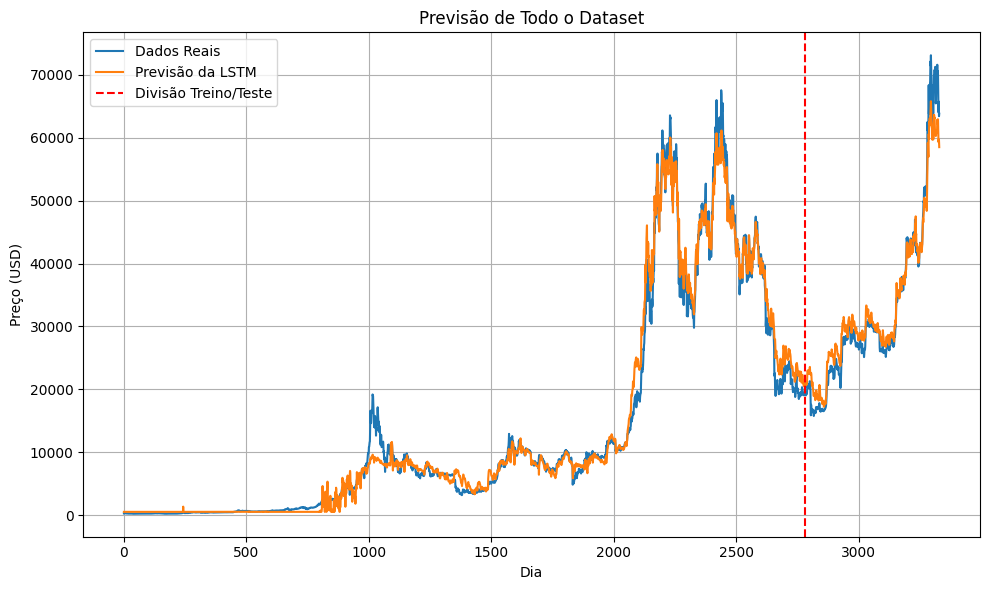

In [444]:
# Divide o dataset em x e y, e aplica transformações de escala
dataset_x_ss = ss.transform(dataset.drop(columns=['close', 'unix']))
dataset_y_mm = mm.transform(dataset.close.values.reshape(-1, 1))

# Divide os dados em sequências de entrada e saída
dataset_x_ss, dataset_y_mm = split_sequences(dataset_x_ss, dataset_y_mm, n_prev_days, n_next_days)

# Converte os dados para tensores, para poder ser usado pelo modelo
dataset_x_ss = torch.Tensor(dataset_x_ss)
datatset_y_mm = torch.Tensor(dataset_y_mm)

# Altera a forma do tensor de entrada
dataset_x_ss = torch.reshape(dataset_x_ss, (dataset_x_ss.shape[0], n_prev_days, dataset_x_ss.shape[2]))

# Roda o modelo sobre as sequências de entrada
train_predict = best_model(dataset_x_ss)

data_predict = train_predict.detach().numpy()
dataY_plot = dataset_y_mm
# Transformação inversa, para plotar como no dataset original
data_predict = mm.inverse_transform(data_predict)
dataY_plot = mm.inverse_transform(dataY_plot)

# Conversão para listas
targets, preds = [], []

for i in range(len(dataY_plot)):
    targets.append(dataY_plot[i][0])

for i in range(len(data_predict)):
    preds.append(data_predict[i][0])

# Plot
plt.figure(figsize=(10, 6))

plt.plot(targets, label='Dados Reais')
plt.plot(preds, label='Previsão da LSTM')
plt.title('Previsão de Todo o Dataset')
plt.xlabel('Dia')
plt.ylabel('Preço (USD)')
plt.axvline(x=(len(dataset) - train_test_cutoff), c='r', linestyle='--', label='Divisão Treino/Teste')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show() 

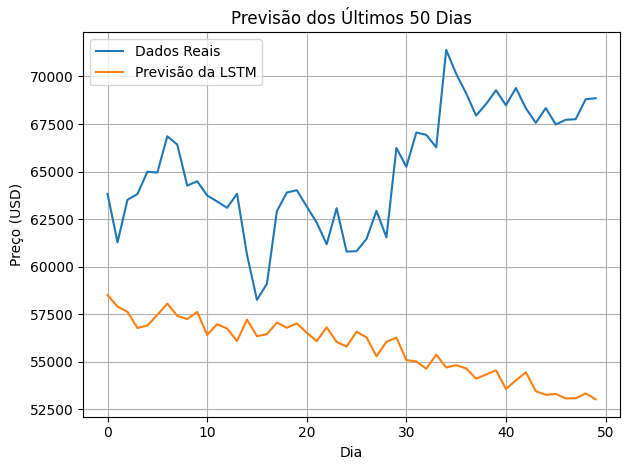

In [445]:
test_predict = best_model(x_test_tensors_final[-1].unsqueeze(0)) # Get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # Last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

# Plot
plt.plot(test_target, label='Dados Reais')
plt.plot(test_predict, label='Previsão da LSTM')
plt.title(f'Previsão dos Últimos {n_next_days} Dias')
plt.xlabel('Dia')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

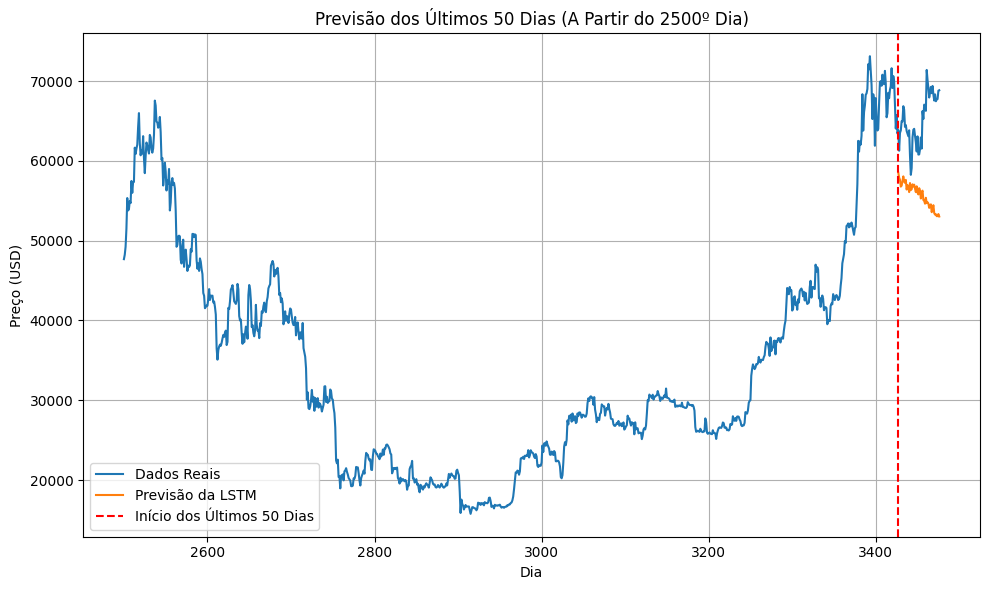

In [446]:
plt.figure(figsize=(10, 6))

targets = [x for x in range(2500, len(y))]
plt.plot(targets, y[2500:], label='Dados Reais')
preds = [x for x in range(len(y) - n_next_days, len(y))]
plt.plot(preds, test_predict, label='Previsão da LSTM')
plt.title(f'Previsão dos Últimos {n_next_days} Dias (A Partir do 2500º Dia)')
plt.xlabel('Dia')
plt.ylabel('Preço (USD)')
plt.axvline(x=(len(y) - n_next_days), c='r', linestyle='--', label='Início dos Últimos 50 Dias')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()